# Plotando com Makie 

Existem diversos pacotes para plotagem com Julia (e.g. Plots.jl, VegaLite.jl, Gadfly.jl,...), entretanto,
o pacote Makie vem ganhando destaque. Na comunidade de Julia, é comum ouvir que "Makie is the future!".
As razões são diversas, entre elas está o fato de o pacote ser totalmente nativo em Julia, simples iteratividade,
bom sistema de layout, entre outros. Mas o que me convenceu (e possivelmente outros da comunidade),
foram alguns dos belíssimos exmemplos de plots como os presentes no repositório [BeautifulMakie](https://lazarusa.github.io/BeautifulMakie/).

Além disso, muitos pacotes interessantes tem sido construídos em cima do Makie, como o [AlgebraOfGraphics.jl](https://github.com/JuliaPlots/AlgebraOfGraphics.jl).

Entretanto, é preciso falar alguns dos atuais "shortcomings". O primeiro é algo bastante
comum para quem usa Julia. O tempo para gerar o primeiro plot considerável devido ao tempo de pré-compilção (felizmente,
isso pode ser contornado com o PkgCompiler.jl, olhe esse meu [artigo aqui](https://medium.com/coffee-in-a-klein-bottle/speeding-up-julia-precompilation-97f39d151a9f)). O segundo problema é que o pacote ainda está em franco desenvolvimento, e não está tão maduro
como o Plots.jl. Assim, não é incomum encontrar bugs de vez em quando, ou descobrir que uma feature
específica ainda não foi implementada.

Mesmo assim, esses são somente percalços frente ao que o Makie pode oferecer.

*obs: sugiro fortemente seguir o tutorial [aqui](https://medium.com/coffee-in-a-klein-bottle/speeding-up-julia-precompilation-97f39d151a9f) para
agilizar a pré-compilação.*

## Passo Iniciais - Plots, Backends e Temas

Diria que o Matplotlib é a biblioteca que mais se parace com o Makie em termos de utilização. Ambos são muito
verstáteis, porém, disponibilizam uma série de funções para realizar plots básicos, como
`scatter`, `lines`, `heatmap`, etc.

Entretanto, a medida que vamos se aprofundando no Makie, veremos que existem diferenças significativas entre esses pacotes.

O primeiro ponto não convencional ao se usar o Makie é o fato que ele permimte o uso de diferentes
backends para plotagem. Eles são:
* CairoMakie - produz imagens estáticas e de alta qualidade (e.g. svg), sendo assim ideal para usar quando se quer produzir um imagem para publicação;
* GLMakie - requer que você tenha instalado no seu computador o OpenGL, e ao plotar é aberta uma janela iterativa contendo o plot;
* WGLMakie - produz visualizações interativas em 2D e 3D. Utiliza WebGL que roda no browser.

In [1]:
using Pkg
Pkg.activate(".")
using CairoMakie

  Activating environment at `~/MEGA/EMAp/Julia_Tutorials/Visualizations/Project.toml`


Você pode importar mais de um backend (e.g. `using GLMakie, CairoMakie`). Por padrão, o que for importado
primeiro será aquele sendo utilizado. Para alterar o backend, use o comando `activate!` daquele backend, por exemplo,
`CairoMakie.activate!()`. Além disso, a função `activate!` também aceita argumentos, como `type="svg"`, o que
indica que as figuras serão em formato "svg".

In [43]:
CairoMakie.activate!(type = "svg")

A função `set_theme!(theme; kwargs...)` nos permite especificar padrões de estilo, como, por exemplo, o tamanho padrão das nossas imagens 
que corresponde ao atributo `resolution = (height,width)`.
Existem vários temas prontos para serem usados, e.g.:
`theme_ggplot2()`, `theme_minimal()`, `theme_black()`, `theme_light()`e `theme_dark()`. Se você gostou de um tema, mas
gostaria de mudar alguns atributos, utilize a função `update_theme!()` ou utilize a `set_theme!(theme;kwargs)` passando
os atributos que deseja alterar.

Caso você queira usar um tema para cada plot, é possível com a função `with_theme()`. Note, porém, que
a função deve ser aplicada antes de você efetivamente gerar sua figura. Ou seja,
a função `with_theme(f,theme=Theme(); kwargs...)` recebe uma função `f` que gera o plot e atribui seu tema.
Se estiver utilizando um notebook Jupyter, você pode utilizar o CaiorMakie para gerar imagens dentro do notebook,
ou então utilizar o GLMakie e o comando `Makie.inline!(true)`. Caso não utilize esse comando, o GLMakie irá
abrir uma janela iterativa com o plot.



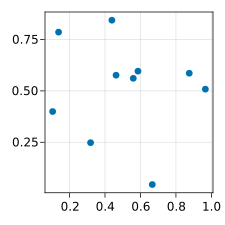

In [44]:
scatter(rand(10,2),figure=(;resolution=(300,300)))

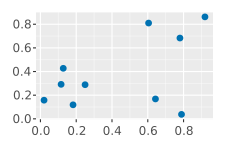

In [45]:
function myplot()
    f, ax, plt = scatter(rand(10,2))
    return f
end
with_theme(myplot, theme_ggplot2(), resolution=(300,200))

*Pro tip*: Alguns pacotes, como o AlgebraOfGraphics.jl, podem possuir temas que você queira utilizar. É possível
importar esses temas e depois modificá-los para seu uso pessoal.

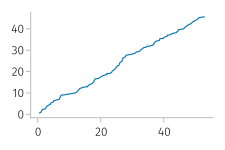

In [46]:
import AlgebraOfGraphics: aog_theme
set_theme!(;resolution=(300,200),aog_theme()...)
lines(cumsum(rand(100,2),dims=1))

Caso queira verificar os atributos sendo utilizado pelo tema vigente, utilize `Makie.current_default_theme()`. Também é
possível salvar um tema personalizado.

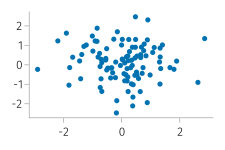

In [47]:
# my_theme = Theme(resolution = (500, 500), color = :red)
my_theme = Makie.current_default_theme()
with_theme(my_theme, color = :blue, linestyle = :dashed) do
    scatter(randn(100, 2))
end

Comandos como `scatter()` produzem um objeto `FigureAxisPlot` que contém uma figura (`Figure`), um conjunto de eixos (`Axis`)  e o plot (`plot`). 
É possível atribuir uma variável para cada um desses atributos, como feito no exemplo acima (`f, ax, pltobj = scatter(rand(10,2))`), ou então
utilizar uma única variável e acessar cada um desses objetos.
Outro ponto importante é que sempre que uma figura é gerada no `Makie`, ela é implicitamente definida como "atual" e pode
ser acessada através da função `curret_figure()`.

In [48]:
fxp = scatter(rand(10,2))
fxp.axis, fxp.figure, fxp.plot;
current_figure();

Caso você só queira fazer algum tipo de visualização padrão (e.g. um scatter plot ou algo do tipo), Makie já possui uma série de funções rápidas
e fáceis de utilizar. Entretanto, caso você queira produzir visualizações mais complexas, e que requerem algum tipo de customização, é ideal entender como o pacote realmente funciona.

## Criando Figuras 

ax = Axis(f[1, 1], xlabel = "x label", ylabel = "y label",
    title = "Title")Vamos construir nossa visualização de maneira bem genérica, criando primeiro a figura, depois os eixos e por fim
nosso plot.
A figura é o container onde mora nossa visualização. Ao criar uma figura, podemos passar os atributos
`resolution` (tamanho da figura), `font`(famíla da fonte), `fontsize`,
`backgroundcolor` e `figure_padding`(espaçamento para plot dentro da figura).


*Tip*: Acesse a documentação do pacote [Colors.jl](https://juliagraphics.github.io/Colors.jl/stable/namedcolors/)
para obter uma lista de cores já com nomes.

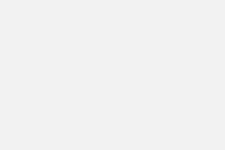

In [49]:
fig = Figure(resolution=(300, 200), font="CMU Serif", backgroundcolor=:grey95, figure_padding=(10,10,5,5)) 

*Obs*: O atributo `figure_padding` corresponde a (esquerda, direita, baixo, cima). Caso passe apenas um valor invés de uma
quádrupla, será atribuido o mesmo valor para todas as posições, i.e. `figure_padding=10` equivale a `figure_padding=(10,10,10,10)`.

As figuras do Makie possuem uma estrutura de malha internamente, sendo muito fácil plotar
imagens lado a lado, ou uma embaixo da outra. Esse objeto é chamado de `GridPosition`.

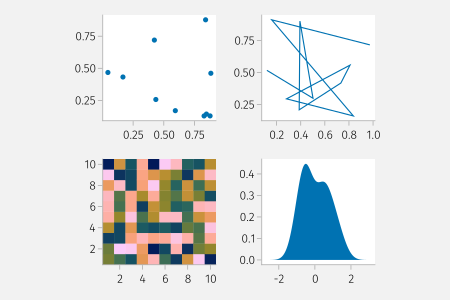

In [50]:
fig = Figure(resolution=(600, 400), backgroundcolor=:grey95, figure_padding=(100,100,20,20)) 
pos1 = fig[1,1]
pos2 = fig[1,2]
pos3 = fig[2,1]
pos4 = fig[2,2]
scatter(pos1, rand(10,2))
lines(pos2, rand(10,2))
heatmap(pos3, rand(10,10))
density(pos4, randn(10))
fig

É possível ir além e criar `SubGridPosition`.

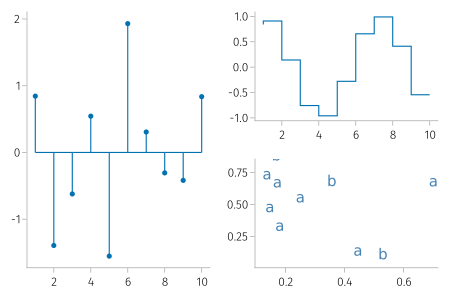

In [51]:
fig = Figure(resolution=(600, 400)) 
stem(fig[1,1], randn(10))
stairs(fig[1,2][1,1], 1:10, x->sin(x) )
text(fig[1,2][2,1], rand(["a","b"],10), position=Point.(rand(10), rand(10)), color=:steelblue)
fig

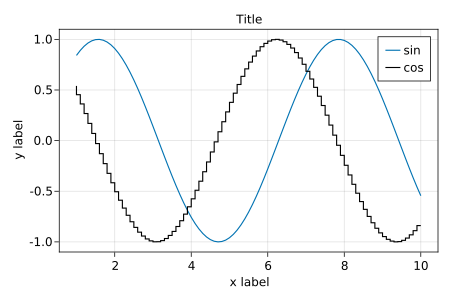

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x00000000078ecb60, 1200.0, 800.0)


In [34]:
fig = Figure(resolution=(600, 400)) 
ax = Axis(fig[1, 1], xlabel = "x label", ylabel = "y label",
    title = "Title")
lines!(ax, 1:0.1:10, x->sin(x), label="sin")
stairs!(ax, 1:0.1:10, x->cos(x), label="cos", color=:black)
axislegend(ax)
display(fig)
save("fig2.png", fig,  px_per_unit = 2)

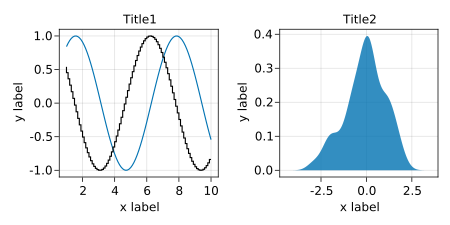

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x0000000007712f70, 1200.0, 600.0)


In [41]:
fig = Figure(resolution=(600, 300)) 
ax1 = Axis(fig[1, 1], xlabel = "x label", ylabel = "y label",
    title = "Title1")
ax2 = Axis(fig[1, 2], xlabel = "x label", ylabel = "y label",
    title = "Title2")
lines!(ax1, 1:0.1:10, x->sin(x), label="sin")
stairs!(ax1, 1:0.1:10, x->cos(x), label="cos", color=:black)

density!(ax2, randn(100))

axislegend(ax)
display(fig)
save("fig3.png", fig,  px_per_unit = 2)

```
axislegend(ax, args...; position = :rt, kwargs...)
axislegend(ax, args...; position = (1, 1), kwargs...)
axislegend(ax = current_axis(); kwargs...)
axislegend(title::AbstractString; kwargs...)
```

Create a legend that sits inside an Axis's plot area.

The position can be a Symbol where the first letter controls the horizontal alignment and can be l, r or c, and the second letter controls the vertical alignment and can be t, b or c. Or it can be a tuple where the first element is set as the Legend's halign and the second element as its valign.


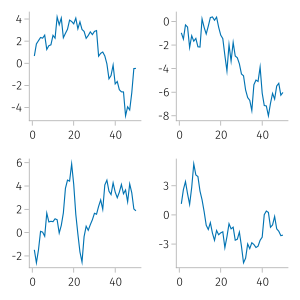

In [53]:
function example_plot()
    f = Figure()
    for i in 1:2, j in 1:2
        lines(f[i, j], cumsum(randn(50)))
    end
    f
end

example_plot()

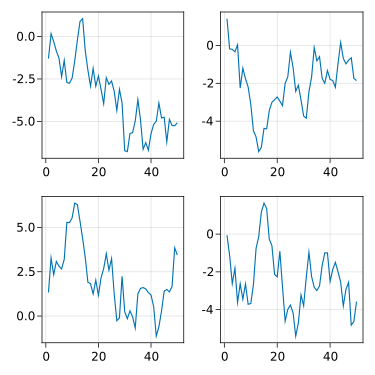

In [54]:
my_theme = Theme(resolution = (500, 500), color = :red)
with_theme(my_theme, color = :blue, linestyle = :dashed) do
    scatter(randn(100, 2))
end
with_theme(example_plot,my_theme)

In [ ]:
f = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (1000, 700));

In [ ]:
ga = f[1, 1] = GridLayout()
gb = f[2, 1] = GridLayout()
gcd = f[1:2, 2] = GridLayout()
gc = gcd[1, 1] = GridLayout()
gd = gcd[2, 1] = GridLayout()

In [ ]:
fig, ax, pltobj = scatterlines(1:10);

In [ ]:
propertynames(ax.elements[:yaxis])

In [ ]:
ax.attributes[:flipsig]

In [ ]:
pltobj.attributes

In [ ]:
figure = (; figure_padding=5, resolution=(600,400),
    backgroundcolor=:grey90, fontsize=16, font="sans")

axis = (; xlabel="x", ylabel="x²", title="title",
    backgroundcolor=:white, xgridstyle=:dash, ygridstyle=:dash)

f,ax, pltobj = lines(1:10, (1:10).^2; color=:black, linewidth=2, linestyle=:dash, figure, axis);

In [ ]:
f

In [ ]:
ax.elements[:yaxis].elements[:labeltext].attributes[:rotation]= 0.0

In [ ]:
ax.attributes

In [ ]:
ax.elements[:xaxis].attributes

In [ ]:
ax.elements[:yaxis].attributes[:flipped] = true